##Usage
Ensure that the file `herlev_pap_smear.zip` is located in the working directory of the notebook. All cells should complete successfully if executed in order. 

For any additional questions or concerns, please email me at 
f.spigel@gmail.com

##Implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from progressbar import progressbar as pb
from os import listdir

###Conversion from RGB to CIELAB format

In [2]:
from skimage.color import rgb2lab, rgb2gray, lab2rgb
from skimage.io import imread, imshow
import cv2

def print_image_summary(image, labels):
    print('--------------')
    print('Image Details:')
    print('--------------')
    print(f'Image dimensions: {image.shape}')
    print('Channels:')
    
    if len(labels) == 1:
        image = image[..., np.newaxis]
        
    for i, lab in enumerate(labels):
        min_val = np.min(image[:,:,i])
        max_val = np.max(image[:,:,i])
        print(f'{lab} : min={min_val:.4f}, max={max_val:.4f}')
        
def img_to_CIELAB_gs(img):
    return rgb2lab(img/255)[:,:,0]*(255/100)

###Non-local denoising

In [3]:
from skimage.util import img_as_ubyte
import cv2

def nl_denoise(img):
    img_ubyte = img_as_ubyte(img/255)
    img_denoised = cv2.fastNlMeansDenoising(img_ubyte, 
                                            None, 
                                            h=20,
                                            templateWindowSize=3,
                                            searchWindowSize=9)
    return img_denoised

###Contrast amplification

In [4]:
def contrast_kernel(x, a=100, b=220):
    k = 1/(b-a)
    l = -k*a
    return max(min(x*k+l, 255), 0)

contrast_kernel_vec = np.vectorize(contrast_kernel, [float])
def amplify_contrast(img, a=100, b=220):
    return contrast_kernel_vec(img, a, b)

###Spatial k-means implementation

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from progressbar import progressbar as pb
from time import time
import cv2

def generate_pixel_coordinates(img, w_size=1):
    # print('building coordinates')
    m, n = img.shape
    med_idx = int(np.floor(((w_size*2+1)**2)/2)+1)
    mean_coeff = (w_size*2+1)**2

    # Add border
    img_expanded = np.zeros((m+2*w_size,n+2*w_size))
    img_expanded[w_size:-w_size,w_size:-w_size] = img
    img_expanded[0:w_size,w_size:-w_size] = img[0,:]
    img_expanded[-w_size:,w_size:-w_size:] = img[-1,:]
    img_expanded[w_size:-w_size,0:w_size] = img[:,0].reshape(-1,1)
    img_expanded[w_size:-w_size,-w_size:] = img[:,-1].reshape(-1,1)

    coordinates = np.zeros((m*n,3))

    # Generate [f, f_mean, f_median] for each pixel
    # and save them to an m*n-by-3 matrix
    for i in range(w_size, m+w_size):
        for j in range(w_size, n+w_size):
            im_slice = img_expanded[i-w_size:i+w_size+1,j-w_size:j+w_size+1]
            coordinates[(i-w_size)*n+(j-w_size),:] = [
                np.float32(img_expanded[i,j]), # value
                np.float32(np.sum(im_slice)/mean_coeff), # mean
                np.float32(np.sort(im_slice.reshape(-1,1))[med_idx,0]) # median
                # (i-w_size)/10,
                # (j-w_size)/10 # position
            ]
    return np.float32(coordinates)

def index_to_img(index, m, n):
    # print('converting pixel indices to image format')
    img = np.zeros((m,n))
    for i in range(m):
        for j in range(n):
            try:
                img[i,j] = index[i*n+j]
            except ValueError as e:
                print(e)
                print(index)
                raise RuntimeError('problems with index_to_img()')
    return img

def spatial_kmeans(inputs, k=3, iterations=10):
    # print('applying k-means')
    return cv2.kmeans(data = inputs,
                      K = k,
                      bestLabels = None,
                      criteria = (cv2.TERM_CRITERIA_MAX_ITER, iterations, 0),
                      attempts = 2,
                      flags = cv2.KMEANS_RANDOM_CENTERS)

    # OLD, MANUAL IMPLEMENTATION - DEPRECATED
    # dim = inputs.shape[1]
    # n = inputs.shape[0]
    
    # # Define initial centroid values
    # centroids = np.zeros((k, dim))
    # for i in range(dim):
    #     centroids[:,i] = np.linspace(np.min(inputs[:,i]), np.max(inputs[:,i]), k)
    # index = np.zeros(n)
    # errors = []
    # print('applying k-means', flush=True)
    # for i in pb(range(iterations)):
    #     # Build index (find closest centroid for each input vector)
    #     errors_current = 0
    #     for j in range(n):
    #         try:
    #             dis = np.linalg.norm(centroids-inputs[j,:], axis=1)
    #             ind = np.where(dis == np.min(dis))[0][0]
    #             index[j] = int(ind)
    #             errors_current = errors_current + dis[int(ind)]
    #         except TypeError as e:
    #             print(flush=True)
    #             print(e, flush=True)
    #             print(f'dis: {dis}\nind: {ind}\ninput: {inputs[j]}\ncentroids:\n{centroids}misc: {np.where(dis == np.min(dis))}')
    #             return
    #     errors.append(errors_current)
    #     # Account for hanging centroids
    #     for j in range(k):
    #         if sum(index==j) == 0: index[j] = j
    #     # Move centroids
    #     for j in range(k):
    #         relevant_vectors = inputs[index==j]
    #         centroids[j,:] = np.sum(relevant_vectors, axis=0)/relevant_vectors.shape[0]

    # # Final index
    # index = np.zeros(n)
    # for i in range(n):
    #     dis = np.linalg.norm(centroids-inputs[i,:], axis=1)
    #     index[i] = int(np.where(dis == np.min(dis))[0])
    # print('k-means complete')
    # return centroids, index, errors

###Logistic Regression

In [6]:
def get_ratio(img_segmented):
    nucleus_area = np.sum(img_segmented==0)
    cytoplasm_area = np.sum(img_segmented==1)
    return nucleus_area/(cytoplasm_area+nucleus_area)

###Display Data

In [7]:
def plot_pixels(coordinates, index, centroids, width, height):
    n = centroids.shape[0]
    fig, ax = plt.subplots(3,1, figsize=(10,30), sharex=False, sharey=False)
    for i in range(n):
        ax[0].scatter(coordinates[index==i, 0], coordinates[index==i, 1], marker='.')
        ax[1].scatter(coordinates[index==i, 0], coordinates[index==i, 2], marker='.')
    ax[0].scatter(centroids[:,0], centroids[:,1], marker='o')
    ax[0].set_title('value vs mean')
    ax[1].scatter(centroids[:,0], centroids[:,2], marker='o')
    ax[1].set_title('value vs median')
    ax[2].imshow(index_to_img(index, width, height), cmap='gray')
    ax[2].set_title('segmented image')
    fig.show()

###Processing

In [9]:
from os import listdir

def segment_img(img, segments=3, iter=10):
    img = img_to_CIELAB_gs(img)
    m, n = img.shape
    img = nl_denoise(img)
    coordinates = generate_pixel_coordinates(img)
    comp, index, centroids = spatial_kmeans(coordinates, k=segments, iterations=iter)
    index_rectified = np.zeros(index.shape, dtype=int)
    args = np.argsort(centroids[:,0])
    # print(args)
    for i in range(segments):
        index_rectified[index==args[i]] = i
    return index_to_img(index_rectified, m, n), centroids, comp

def process_folder(path, segments=4, iter=10):
    print(f'processing {path}', flush=True)
    # load files
    files = listdir(path)
    images = []
    for file in files:
        if file[-4:] == '.BMP' and file[-5] != 'd':
            images.append(plt.imread(path+file))

    # process
    ratios = []
    for i, img in enumerate(pb(images)):
        img_segmented, centroids, errors = segment_img(img, segments=4, iter=20)
        img_segmented[img_segmented==2] = 1
        img_segmented[img_segmented==3] = 2
        ratios.append(get_ratio(img_segmented))
    return np.array(ratios)

def predict(images):
    ratios = []
    x = 0.1
    for i, img in enumerate(pb(images)):
        img_segmented, centroids, errors = segment_img(img, segments=4, iter=20)
        img_segmented[img_segmented==2] = 1
        img_segmented[img_segmented==3] = 2
        ratios.append(get_ratio(img_segmented))
    return np.array(np.array(ratios) > x, dtype=int)

def simple_split_metrics(negative, positive, x):
    TN = np.sum(negative<x)
    FN = np.sum(positive<x)
    TP = np.sum(positive>=x)
    FP = np.sum(negative>=x)
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    if TP+FP == 0: precision = 1
    else: precision = TP/(TP+FP)
    if TP+FN == 0: recall = 1
    else: recall = TP/(TP+FN)
    F1 = 2*(precision*recall)/(precision+recall)
    # print('accuracy: {:.2f}\nprecision: {:.2f}\nrecall: {:.2f}\nF1: {:.2f}'.format(accuracy, precision, recall, F1))
    return accuracy, precision, recall, F1

###Unpack data

In [16]:
from zipfile import ZipFile

with ZipFile('herlev_pap_smear.zip') as zf: zf.extractall()

##Execution

###Executing on single images

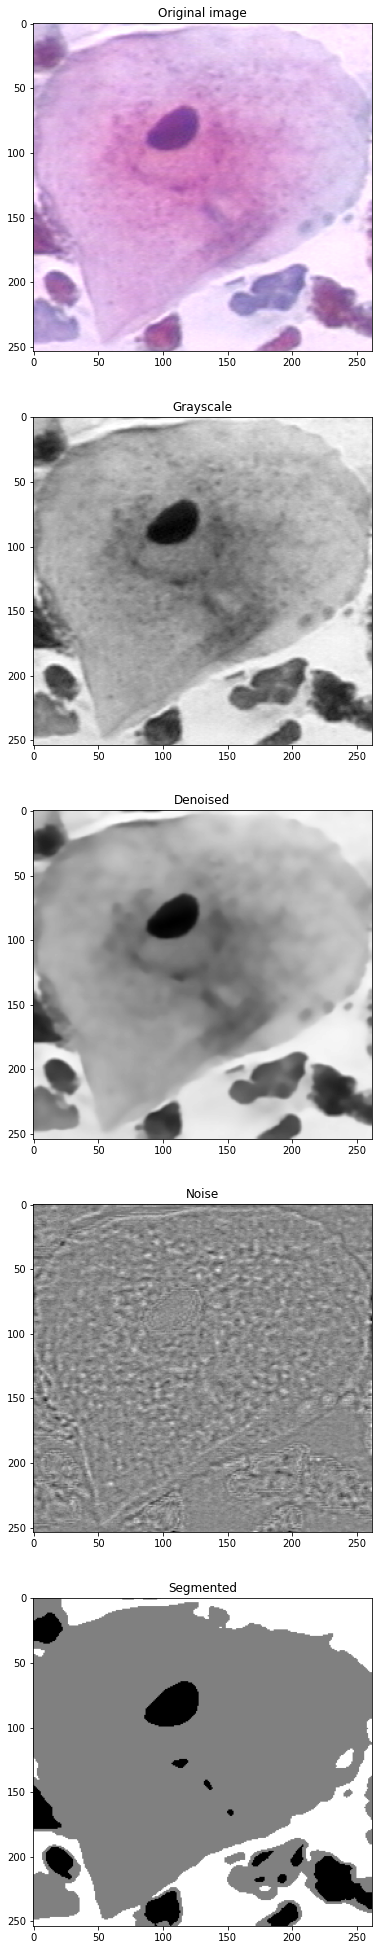

In [30]:
img = plt.imread('herlev_pap_smear/normal_intermediate/153955676-153955746-001.BMP')
img_gs = img_to_CIELAB_gs(img)
img_denoised = nl_denoise(img_gs)
noise = img_denoised-img_gs
segmented_img, centroids, comp = segment_img(img, segments = 4, iter = 20)
segmented_img[segmented_img == 2] = 1
segmented_img[segmented_img == 3] = 2
fig, ax = plt.subplots(5, 1, figsize=(7,35))
ax[0].imshow(img)
ax[0].set_title('Original image')
ax[1].imshow(img_gs, cmap = 'gray')
ax[1].set_title('Grayscale')
ax[2].imshow(img_denoised, cmap = 'gray')
ax[2].set_title('Denoised')
ax[3].imshow(noise, cmap = 'gray')
ax[3].set_title('Noise')
ax[4].imshow(segmented_img, cmap = 'gray')
ax[4].set_title('Segmented')
fig.show()

[]

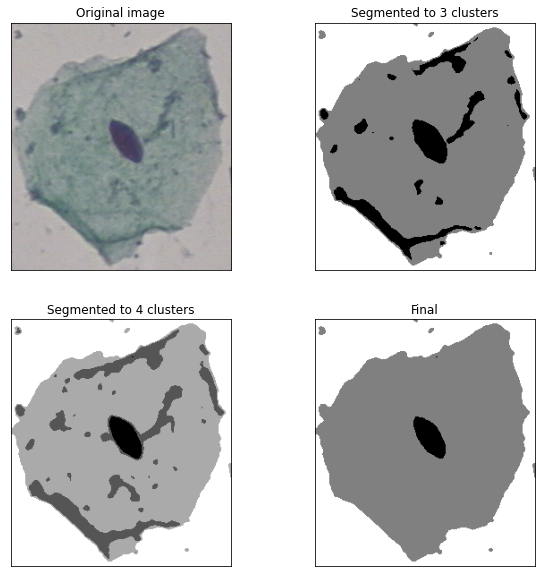

In [50]:
img = plt.imread('herlev_pap_smear/normal_intermediate/157223549-157223570-001.BMP')

seg_3, _, _ = segment_img(img, segments=3, iter=10)
seg_4, _, _ = segment_img(img, segments=4, iter=10)
seg_4_rectified = seg_4.copy()
seg_4_rectified[seg_4 == 2] = 1
seg_4_rectified[seg_4 == 3] = 2

fig, ax = plt.subplots(2,2,figsize=(10,10))
ax[0,0].imshow(img)
ax[0,0].set_title('Original image')
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
ax[0,1].imshow(seg_3, cmap='gray')
ax[0,1].set_title('Segmented to 3 clusters')
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[1,0].imshow(seg_4, cmap='gray')
ax[1,0].set_title('Segmented to 4 clusters')
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
ax[1,1].imshow(seg_4_rectified, cmap='gray')
ax[1,1].set_title('Final')
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])

###Executing on image sets

100% (10 of 10) |########################| Elapsed Time: 0:00:22 Time:  0:00:22


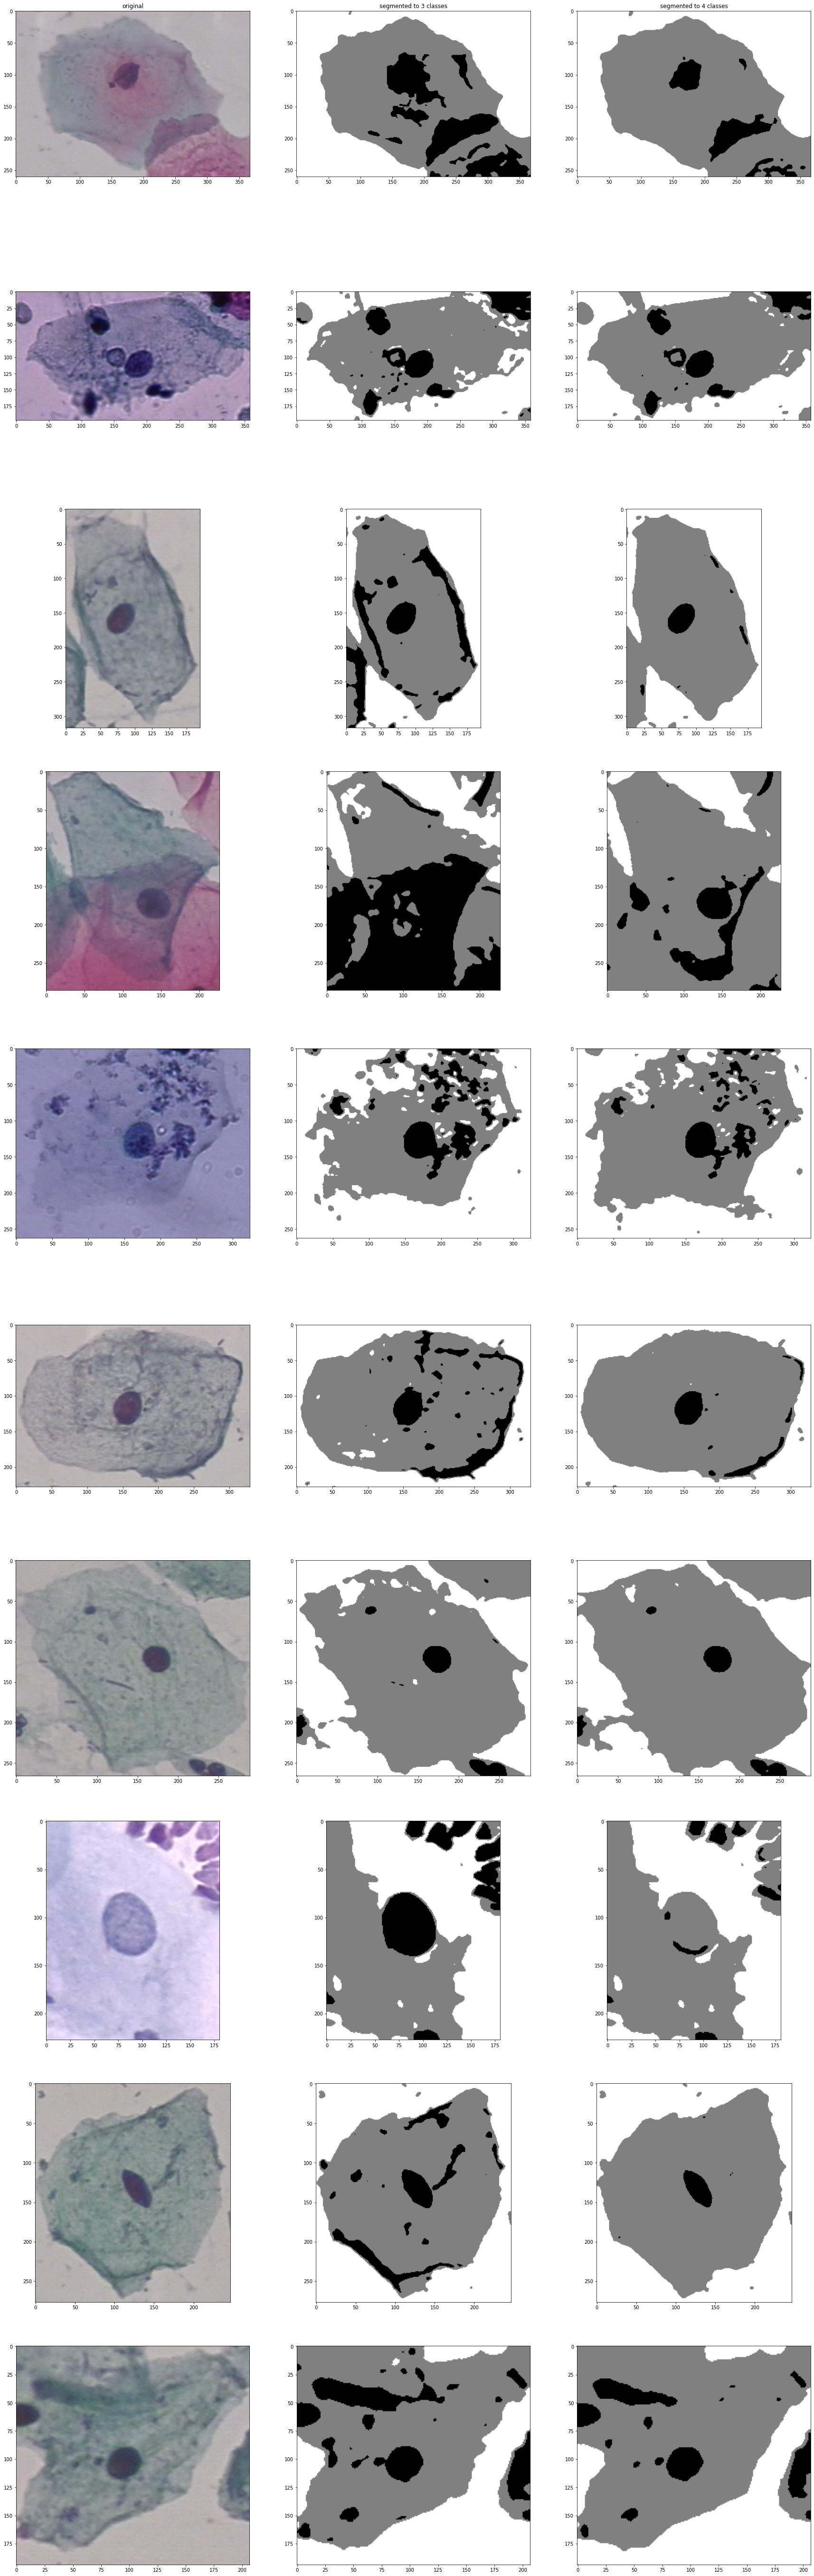

In [38]:
# load files
path = 'herlev_pap_smear/normal_intermediate/'
files = listdir(path)
images = []
i = 10
for file in files:
    if file[-4:] == '.BMP' and file[-5] != 'd':
        images.append(plt.imread(path+file))
        i = i-1
    if i <= 0:
        break;

# process
images_segmented_3 = []
images_segmented_4 = []
fig, ax = plt.subplots(len(images), 3, figsize=(30, 10*len(images)))
for i, img in enumerate(pb(images)):
    img_segmented_3, centroids, errors = segment_img(img, segments=3, iter=10)
    images_segmented_3.append(img_segmented_3)
    img_segmented_4, centroids, errors = segment_img(img, segments=4, iter=10)
    img_segmented_4[img_segmented_4==2] = 1
    img_segmented_4[img_segmented_4==3] = 2
    images_segmented_4.append(img_segmented_4)
    ax[i, 0].imshow(img, cmap='gray')
    ax[i, 1].imshow(img_segmented_3, cmap='gray')
    ax[i, 2].imshow(img_segmented_4, cmap='gray')
ax[0, 0].set_title('original')
ax[0, 1].set_title('segmented to 3 classes')
ax[0, 2].set_title('segmented to 4 classes')
fig.show()

100% (10 of 10) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


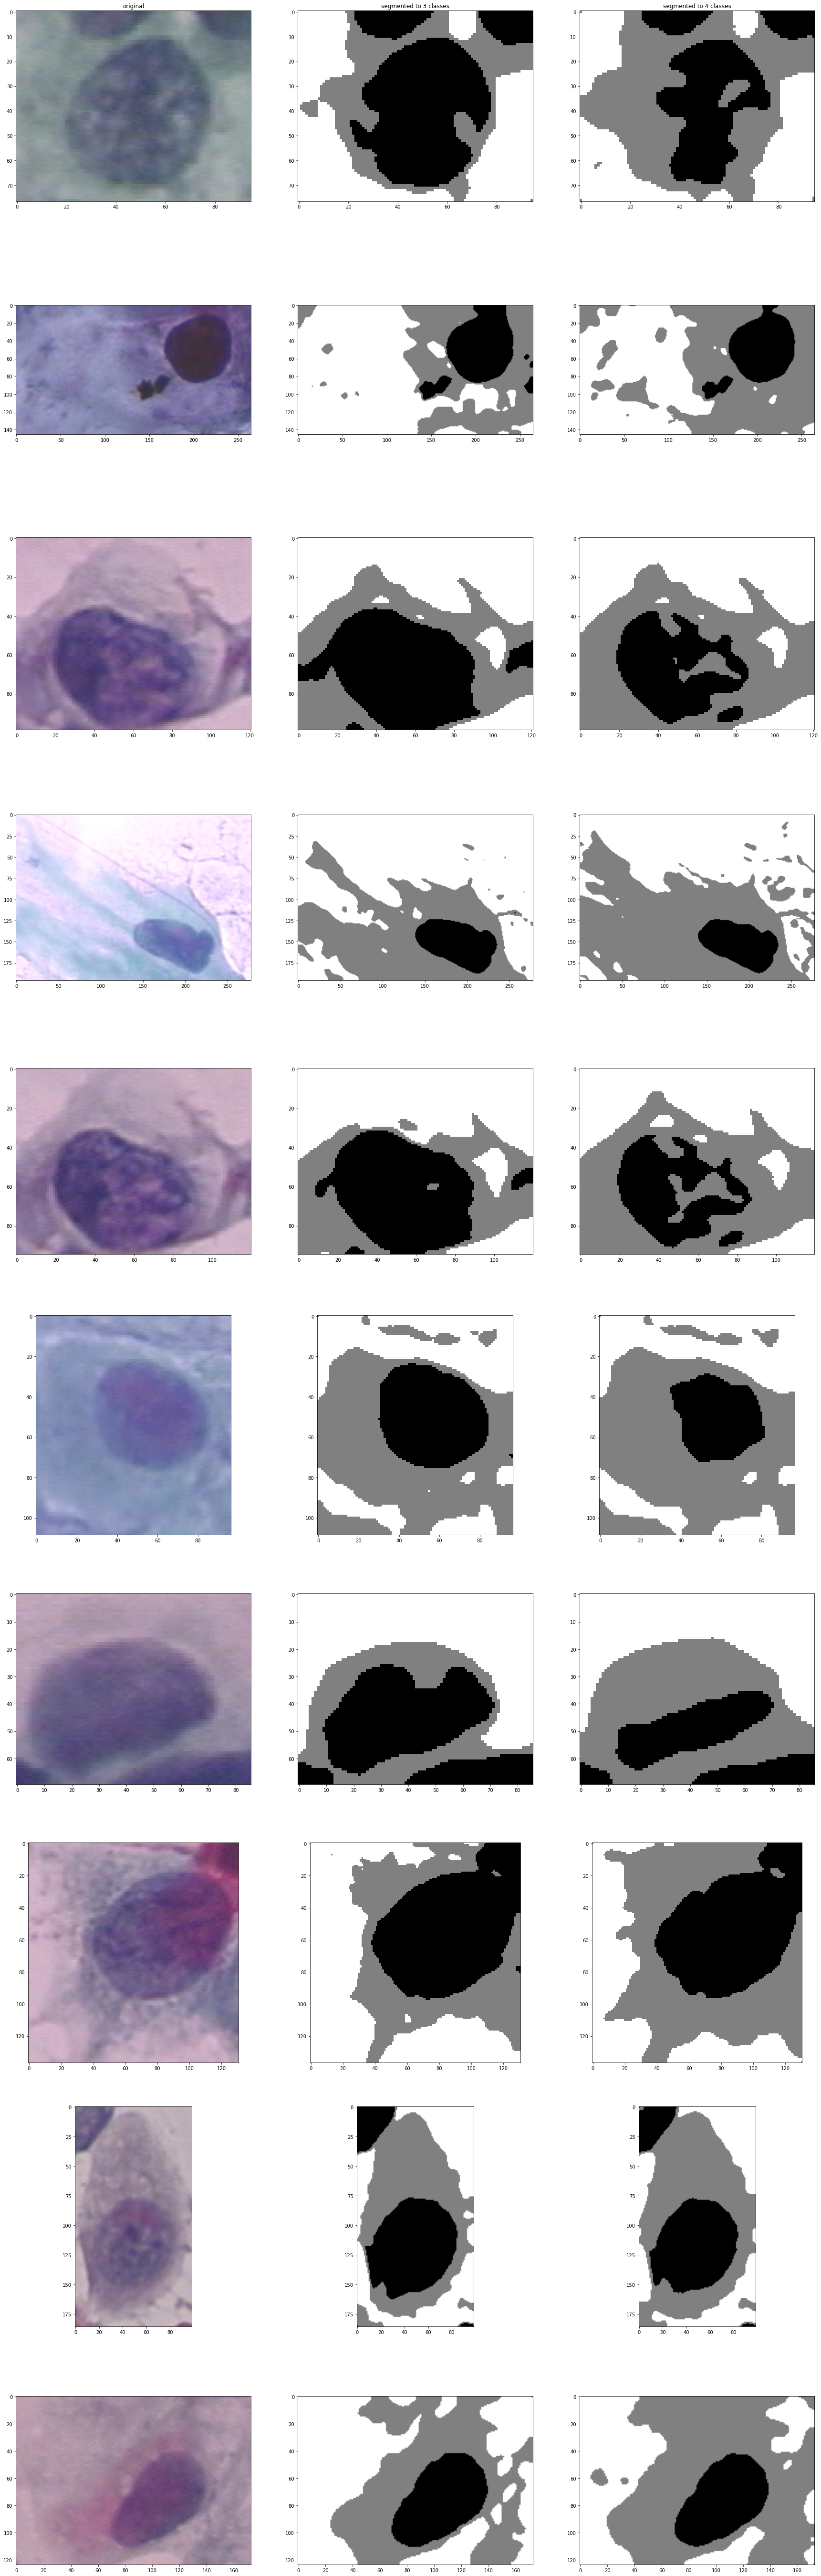

In [43]:
# load files
path = 'herlev_pap_smear/abnormal_moderate_dysplastic/'
files = listdir(path)
images = []
i = 10
for file in files:
    if file[-4:] == '.BMP' and file[-5] != 'd':
        images.append(plt.imread(path+file))
        i = i-1
    if i <= 0:
        break;

# process
images_segmented_3 = []
images_segmented_4 = []
fig, ax = plt.subplots(len(images), 3, figsize=(30, 10*len(images)))
for i, img in enumerate(pb(images)):
    img_segmented_3, centroids, errors = segment_img(img, segments=3, iter=10)
    images_segmented_3.append(img_segmented_3)
    img_segmented_4, centroids, errors = segment_img(img, segments=4, iter=10)
    img_segmented_4[img_segmented_4==2] = 1
    img_segmented_4[img_segmented_4==3] = 2
    images_segmented_4.append(img_segmented_4)
    ax[i, 0].imshow(img, cmap='gray')
    ax[i, 1].imshow(img_segmented_3, cmap='gray')
    ax[i, 2].imshow(img_segmented_4, cmap='gray')
ax[0, 0].set_title('original')
ax[0, 1].set_title('segmented to 3 classes')
ax[0, 2].set_title('segmented to 4 classes')
fig.show()

###Executing on the entire Herlev dataset

In [44]:
ratios_negative = np.concatenate([
                    process_folder('herlev_pap_smear/normal_columnar/'),
                    process_folder('herlev_pap_smear/normal_intermediate/'),
                    process_folder('herlev_pap_smear/normal_superficiel/')
])

ratios_positive = np.concatenate([
                    process_folder('herlev_pap_smear/abnormal_light_dysplastic/'),
                    process_folder('herlev_pap_smear/abnormal_carcinoma_in_situ/'),
                    process_folder('herlev_pap_smear/abnormal_severe_dysplastic/'),
                    process_folder('herlev_pap_smear/abnormal_moderate_dysplastic/')
])

processing herlev_pap_smear/normal_columnar/


100% (98 of 98) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


processing herlev_pap_smear/normal_intermediate/


100% (54 of 54) |########################| Elapsed Time: 0:01:06 Time:  0:01:06


processing herlev_pap_smear/normal_superficiel/


100% (74 of 74) |########################| Elapsed Time: 0:02:18 Time:  0:02:18


processing herlev_pap_smear/abnormal_light_dysplastic/


100% (182 of 182) |######################| Elapsed Time: 0:01:46 Time:  0:01:46


processing herlev_pap_smear/abnormal_carcinoma_in_situ/


100% (150 of 150) |######################| Elapsed Time: 0:00:22 Time:  0:00:22


processing herlev_pap_smear/abnormal_severe_dysplastic/


100% (197 of 197) |######################| Elapsed Time: 0:00:36 Time:  0:00:36


processing herlev_pap_smear/abnormal_moderate_dysplastic/


100% (146 of 146) |######################| Elapsed Time: 0:00:48 Time:  0:00:48


Accuracy: 0.847
Precision: 0.840
Recall: 0.982
F1: 0.906


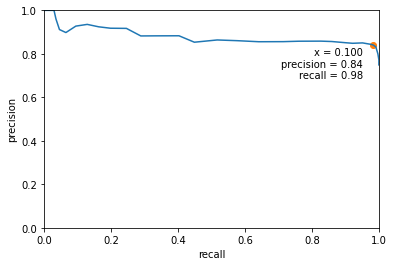

In [45]:
recall = []
precision = []
for x in np.linspace(0,1):
    metrics = simple_split_metrics(ratios_negative, ratios_positive, x)
    precision.append(metrics[1])
    recall.append(metrics[2])
plt.plot(recall, precision)
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('recall')
plt.ylabel('precision')
x = 0.10
acc, prec, rec, F1 = simple_split_metrics(ratios_negative, ratios_positive, x)
plt.scatter([rec], [prec], c='C1')
plt.text(rec-0.03, prec-0.01, 'x = {:.3f}\nprecision = {:.2f}\nrecall = {:.2f}'.format(x, prec, rec), horizontalalignment='right', verticalalignment='top')
print('Accuracy: {:.3f}\nPrecision: {:.3f}\nRecall: {:.3f}\nF1: {:.3f}'.format(acc, prec, rec, F1))
plt.show()

In [48]:
acc, prec, rec, F1 = simple_split_metrics(ratios_negative, ratios_positive, 0.1)
print('Accuracy: {:.2f}\nPrecision: {:.2f}\nRecall:{:.2f}\nF1 score: {:.2f}'.format(acc, prec, rec, F1))

Accuracy: 0.85
Precision: 0.84
Recall:0.98
F1 score: 0.91


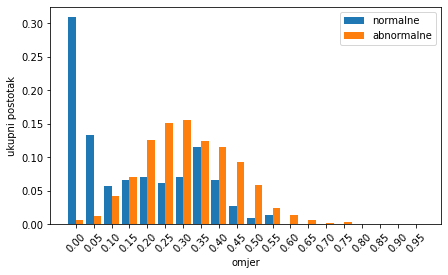

In [49]:
num_brackets = 20
brackets = np.linspace(0,1,num_brackets+1)
width = 1/(num_brackets-1)
bar_width = width/2.5
bars_neg = []
for i in range(len(brackets)-1): bars_neg.append(np.sum(ratios_negative[ratios_negative > brackets[i]] < brackets[i+1])/len(ratios_negative))
bars_pos = []
for i in range(len(brackets)-1): bars_pos.append(np.sum(ratios_positive[ratios_positive > brackets[i]] < brackets[i+1])/len(ratios_positive))
plt.figure(figsize=(7, 4))
plt.bar(brackets[:-1]-bar_width, bars_neg, width = bar_width, align='edge')
plt.bar(brackets[:-1], bars_pos, width = bar_width, align='edge')
plt.xticks(brackets[:-1], rotation=45)
plt.legend(['normalne', 'abnormalne'])
plt.xlabel('omjer')
plt.ylabel('ukupni postotak')
plt.show()